In [1]:
from pathlib import Path

parent_dir = str(Path.cwd().parent)
%cd $parent_dir

/Users/tomtalpir/Random/pyERGM


In [39]:
import numpy as np
import pandas as pd
import torch
import random
import time
from utils import get_random_edges_to_flip, np_tensor_to_sparse_tensor, transpose_sparse_sample_matrices
from metrics import *

import seaborn as sns
import matplotlib.pyplot as plt

import gc


In [40]:
n = 100
num_nets = 100000
p = 0.1

n_of_attempts = 100
all_times = []
for i in range(n_of_attempts):    
    times = {}
    network_samples = np.zeros((n,n,num_nets))
    all_pairs = np.random.binomial(n, p, size=num_nets)

    t1 = time.time()
    for net_idx in range(num_nets):
        num_of_pairs = all_pairs[net_idx]
        random_indices = get_random_edges_to_flip(n, num_of_pairs)
        network_samples[random_indices[0], random_indices[1], net_idx] = 1

    t2 = time.time()
    times["np_initialization_time"] = t2 - t1

    t1 = time.time()
    sparse_network_samples = np_tensor_to_sparse_tensor(network_samples)
    t2 = time.time()
    times["conversion_time"] = t2 - t1

    t1 = time.time()
    np_sum = NumberOfEdgesDirected.calculate_for_sample(network_samples)
    t2 = time.time()

    times["np_sum_time"] = t2 - t1

    t1 = time.time()
    sparse_sum = NumberOfEdgesDirected.calculate_for_sample(sparse_network_samples)
    t2 = time.time()

    times["sparse_sum_time"] = t2 - t1

    t1 = time.time()
    numpy_reciprocity = TotalReciprocity.calculate_for_sample(network_samples)
    t2 = time.time()
    times["np_reciprocity_time"] = t2 - t1

    t1 = time.time()
    sparse_reciprocity = TotalReciprocity.calculate_for_sample(sparse_network_samples)
    t2 = time.time()
    times["sparse_reciprocity_time"] = t2 - t1

    print(f"Attempt {i+1}")
    print(times)
    print("\n\n")
    all_times.append(times)

    
    del network_samples
    del sparse_network_samples
    gc.collect()



Attempt 1
{'np_initialization_time': 1.1617581844329834, 'conversion_time': 3.721050977706909, 'np_sum_time': 1.8529770374298096, 'sparse_sum_time': 0.0818169116973877, 'np_reciprocity_time': 2.6139793395996094, 'sparse_reciprocity_time': 0.12047004699707031}



Attempt 2
{'np_initialization_time': 1.1634752750396729, 'conversion_time': 3.7793641090393066, 'np_sum_time': 1.6658618450164795, 'sparse_sum_time': 0.08218502998352051, 'np_reciprocity_time': 2.377856969833374, 'sparse_reciprocity_time': 0.11676216125488281}



Attempt 3
{'np_initialization_time': 1.2196910381317139, 'conversion_time': 4.301807880401611, 'np_sum_time': 1.8023970127105713, 'sparse_sum_time': 0.08321213722229004, 'np_reciprocity_time': 2.5866379737854004, 'sparse_reciprocity_time': 0.1263599395751953}



Attempt 4
{'np_initialization_time': 1.0565040111541748, 'conversion_time': 3.786595106124878, 'np_sum_time': 1.6599769592285156, 'sparse_sum_time': 0.08024406433105469, 'np_reciprocity_time': 2.362829923629760

KeyboardInterrupt: 

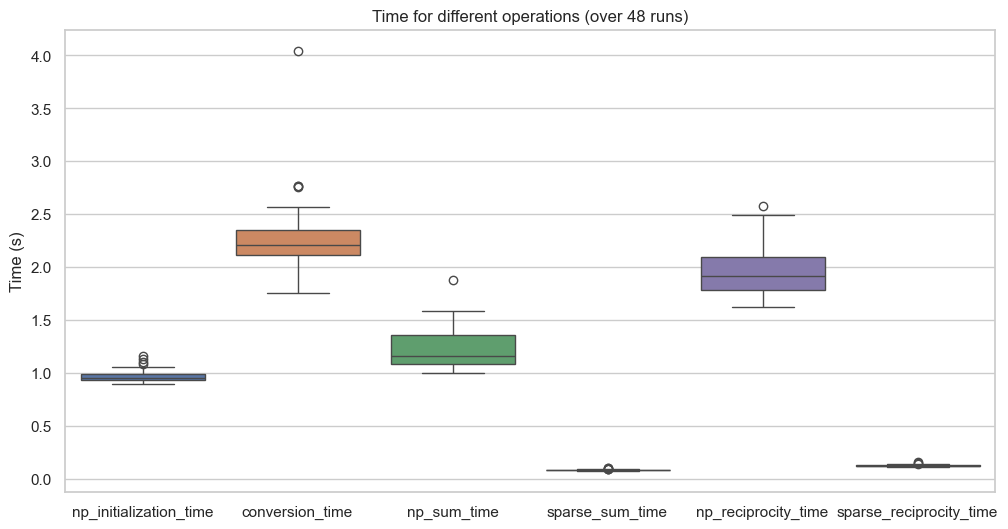

In [38]:

mem_fix_all_times_df = pd.DataFrame(all_times)

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=mem_fix_all_times_df, ax=ax)
ax.set_title("Time for different operations, AFTER MEM FIX (over 48 runs)")
ax.set_ylabel("Time (s)")

plt.show()


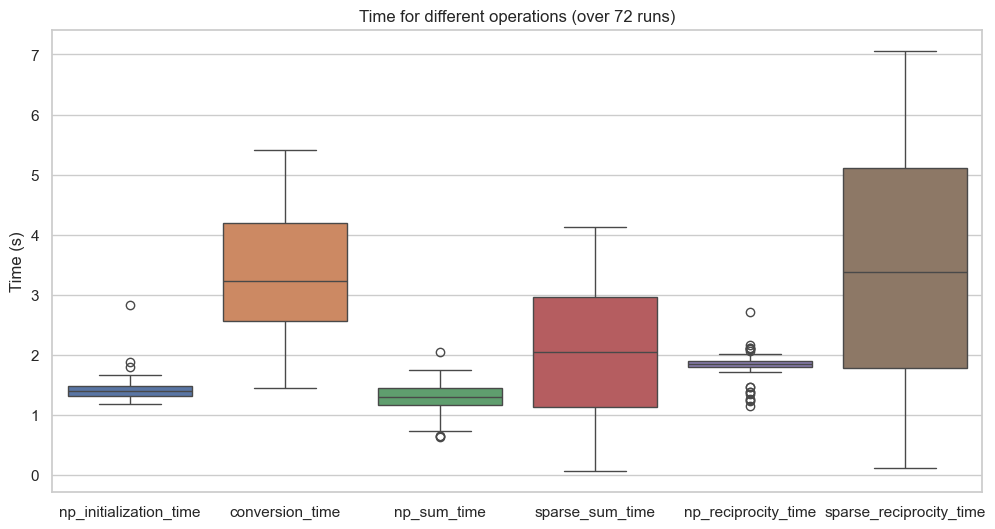

In [34]:

all_times_df = pd.DataFrame(all_times)

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=all_times_df, ax=ax)
ax.set_title("Time for different operations (over 72 runs)")
ax.set_ylabel("Time (s)")

plt.show()


In [33]:
all_times_df.describe()

,np_initialization_time,conversion_time,np_sum_time,sparse_sum_time,np_reciprocity_time,sparse_reciprocity_time
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,1.427056,3.283383,1.280829,2.040936,1.819198,3.437061
std,0.212657,0.995484,0.253661,1.118284,0.232561,1.954249
min,1.187895,1.447345,0.627717,0.074899,1.148876,0.118968
25%,1.316348,2.567822,1.164468,1.133423,1.794797,1.780089
50%,1.403098,3.223773,1.296067,2.054778,1.848859,3.385884
75%,1.475436,4.187607,1.453281,2.967243,1.899611,5.111546
max,2.828033,5.408408,2.042871,4.135652,2.711854,7.063065


In [9]:
t1 = time.time()
numpy_reciprocity = np.einsum("ijk,jik->k", empty_W, empty_W)
t2 = time.time()
print(f"Total time for np einsum: {t2-t1} s")

Total time for np einsum: 1.4242238998413086 s


In [10]:
t1 = time.time()
W_indices = sparse_W.indices().type(torch.int64)
i = torch.stack([W_indices[1], W_indices[0], W_indices[2]])
v = sparse_W.values()
W_T_sparse = torch.sparse_coo_tensor(i, v, (n, n, num_nets))
sparse_torch_recip = torch.sum(sparse_W * W_T_sparse, axis=(0,1))
t2 = time.time()
print(f"Total time for torch einsum: {t2-t1} s")

Total time for torch einsum: 0.14143729209899902 s


In [88]:
numpy_reciprocity = np.einsum("ijk,jik->k", empty_W, empty_W)

In [90]:
np.all(numpy_reciprocity == sparse_torch_recip)

True

In [14]:
sparse_W.shape

torch.Size([100, 100, 100000])